# Application: Learning optimal restrictions in a continuous-action game

This notebook corresponds to Section 5.1 of the paper "Grams & Oesterle (forthcoming). _DRAMA at the PettingZoo: Dynamically Restricted Action Spaces for Multi-Agent Reinforcement Learning Frameworks_."

## Setup

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os, sys
sys.path.append(f'{os.getcwd()}/../../')

In [13]:
from gymnasium.spaces import Box
import matplotlib.pyplot as plt

from src.wrapper import RestrictionWrapper
from src.restrictors import IntervalUnionActionSpace

from examples.utils import play
from examples.cournot.env import NFGEnvironment
from examples.cournot.agent import UnrestrictedCournotAgent, RestrictedCournotAgent
from examples.cournot.restrictor import CournotRestrictor

## Definition of the Cournot Game

In [14]:
maximum_price = 120
cost = 12

price_space = Box(0, maximum_price)
observation_spaces = {'player_0': price_space, 'player_1': price_space}
action_spaces = {'player_0': price_space, 'player_1': price_space}
utilities = {
    'player_0': (lambda actions: -actions['player_0'] ** 2 - actions['player_0'] * actions['player_1'] + (maximum_price - cost) * actions['player_0']), 
    'player_1': (lambda actions: -actions['player_1'] ** 2 - actions['player_0'] * actions['player_1'] + (maximum_price - cost) * actions['player_1'])}

env = NFGEnvironment(observation_spaces, action_spaces, utilities, number_of_steps=100, render_mode='human')

## Test: Play without restrictions

In [15]:
policies = {'player_0': UnrestrictedCournotAgent(maximum_price, cost).act, 'player_1': UnrestrictedCournotAgent(maximum_price, cost).act}
trajectory = play(env, policies, max_iter=100, render_mode=None, record_trajectory=True)

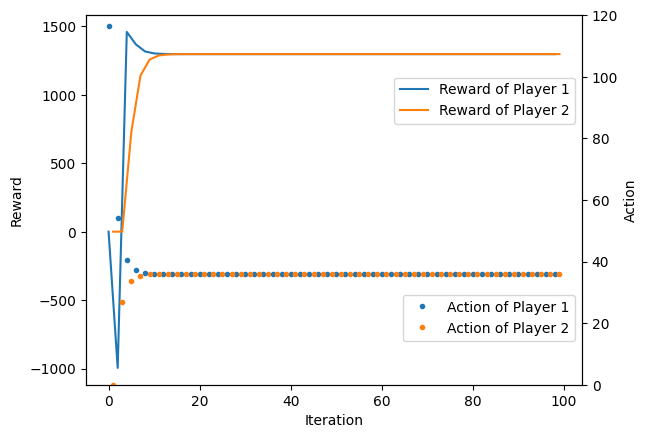

In [16]:
fig, ax_reward = plt.subplots()
ax_action = ax_reward.twinx()

trajectory.groupby('agent')['reward'].plot(ax=ax_reward, style='-')

trajectory.groupby('agent')['action'].plot(ax=ax_action, style='.', ylim=(0, maximum_price))

# reward_grouped = trajectory.groupby('agent')['reward']
# colors = {'player_0': 'blue', 'player_1': 'red'}
# for key, group in reward_grouped:
#     group.plot(ax=ax_reward, style='.-', lw=0.5, color=colors[key])

# action_grouped = trajectory.groupby('agent')['action']
# colors = {'player_0': 'green', 'player_1': 'black'}
# for key, group in action_grouped:
#     group.plot(ax=ax_action, style='.-', lw=0.5, ylim=(0, maximum_price), color=colors[key])

ax_reward.xaxis.set_label_text('Iteration')
ax_reward.yaxis.set_label_text('Reward')
ax_action.yaxis.set_label_text('Action')

ax_reward.legend(['Reward of Player 1', 'Reward of Player 2'], loc='upper right', bbox_to_anchor=(1, 0.85))
ax_action.legend(['Action of Player 1', 'Action of Player 2'], loc='lower right', bbox_to_anchor=(1, 0.10));

## Self-learning restrictions

When we run the environment with the `CournotRestrictor`, we see that it observes the agents and waits until their strategies converge. At this point the restrictor estimates the environment parameters (more concretely, the parameter `lambda := maximum_price - cost`) from the observed agent actions, and defines a suitable restriction. The agents then react to the restriction by changing their strategies. Eventually, the restriction gives a reward increase by approximately 12.5%.

In [26]:
number_of_iterations = 100

agents = [RestrictedCournotAgent(maximum_price, cost), RestrictedCournotAgent(maximum_price, cost)]
restrictor = CournotRestrictor(Box(0, maximum_price, shape=(2, )), IntervalUnionActionSpace(Box(0, maximum_price)))
wrapper = RestrictionWrapper(env, restrictor, restrictor_reward_fns={'restrictor_0': lambda env, rewards: rewards[env.agent_selection]})

# Use restrictor for all agents uniformly
policies = {'player_0': agents[0].act, 'player_1': agents[1].act, 'restrictor_0': restrictor.act}

# Run wrapped environment for 100 iterations
trajectory = play(wrapper, policies, max_iter=number_of_iterations, render_mode=None, record_trajectory=True)

In [28]:
trajectory

,agent,observation,reward,termination,truncation,info,action
0,restrictor_0,"[nan, nan]",0.00000,False,False,{},"IntervalUnionRestriction([(0.0, 120.0)])"
1,player_0,"{'observation': [None], 'restriction': Interva...",0.00000,False,False,{},84.646675
2,restrictor_0,"[84.64667517938192, nan]",0.00000,False,False,{},"IntervalUnionRestriction([(0.0, 120.0)])"
3,player_1,"{'observation': [84.64667517938192], 'restrict...",0.00000,False,False,{},11.676662
4,restrictor_0,"[84.64667517938192, 11.676662410309042]",988.39065,False,False,{},"IntervalUnionRestriction([(0.0, 120.0)])"
...,...,...,...,...,...,...,...
95,player_1,"{'observation': [27.000034794813526], 'restric...",1458.00000,False,False,{},27.000035
96,restrictor_0,"[27.000034794813526, 27.000034794813526]",1458.00000,False,False,{},"IntervalUnionRestriction([(0.0, 27.00003479481..."
97,player_0,"{'observation': [27.000034794813526], 'restric...",1458.00000,False,False,{},27.000035
98,restrictor_0,"[27.000034794813526, nan]",1458.00000,False,False,{},"IntervalUnionRestriction([(0.0, 27.00003479481..."


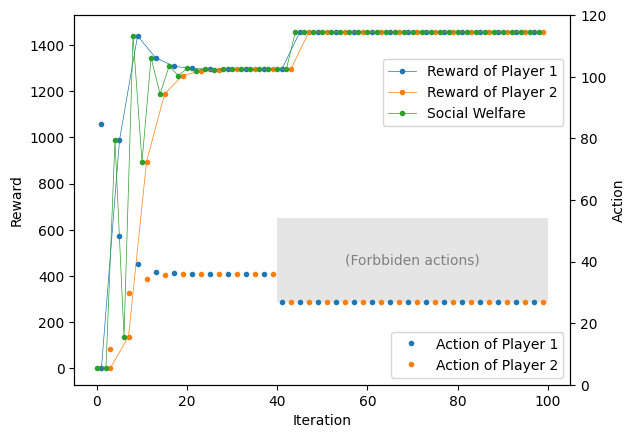

In [31]:
fig, ax_reward = plt.subplots()
ax_action = ax_reward.twinx()

trajectory.groupby('agent')['reward'].plot(style='.-', ax=ax_reward, lw=0.5)
trajectory[trajectory['agent'] != 'restrictor_0'].groupby('agent')['action'].plot(style='.', ax=ax_action, ylim=(0, maximum_price))

ax_reward.xaxis.set_label_text('Iteration')
ax_reward.yaxis.set_label_text('Reward')
ax_action.yaxis.set_label_text('Action')

ax_reward.legend(['Reward of Player 1', 'Reward of Player 2', 'Social Welfare'], loc='upper right', bbox_to_anchor=(1, 0.9))
ax_action.legend(['Action of Player 1', 'Action of Player 2'], loc='lower right', bbox_to_anchor=(1, 0))

# Mark forbidden actions
restrictor_actions = trajectory[trajectory['agent'] == 'restrictor_0']['action']
begin_of_restriction = restrictor_actions.index[restrictor_actions.apply(lambda x: x.size < restrictor_actions.iloc[0].size)].min()
[_, lower_bound], [upper_bound, _] = restrictor_actions.iloc[-1].intervals()

ax_action.fill_between([begin_of_restriction, number_of_iterations], [lower_bound, lower_bound], [upper_bound, upper_bound], alpha=0.2, color='gray', lw=0)
ax_action.text((number_of_iterations + begin_of_restriction) / 2, (lower_bound + upper_bound) / 2, '(Forbbiden actions)', ha='center', va='center', color='gray')


fig.savefig('result.pdf', bbox_inches='tight')

In [22]:
from src.restrictions import IntervalUnionRestriction

r = IntervalUnionRestriction(Box(0, 120))
r.contains(30)

True